## Word2Vec

A shallow NN that can generate a vector space (latent space) for words in a corpus. There are two main architectures:
 - **CBOW**: Given the surround words, try to predict the center word.
 - **Skip-Gram**: Given a word try to predict the surround words.

Also, for better performance different techniques were suggest:
 - **Negative Sampling**
 - **Hierarchical Softmax**
 
## References

#### Papers

 - [Efficient Estimation of Word Representations in Vector Space](http://arxiv.org/pdf/1301.3781.pdf)
 - [Distributed Representations of Words and Phrases and their Compositionality](http://arxiv.org/pdf/1310.4546.pdf)
 - [word2vec Parameter Learning Explained](https://arxiv.org/pdf/1411.2738)
 - [Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053)

#### Blogs
 - [Word2Vec Resources](http://mccormickml.com/2016/04/27/word2vec-resources/)
 - [Python implementation of Word2Vec](http://www.claudiobellei.com/2018/01/07/backprop-word2vec-python/)
 - [The backpropagation algorithm for Word2Vec ](http://www.claudiobellei.com/2018/01/06/backprop-word2vec/)
 - [Word2vec from Scratch with NumPy](https://towardsdatascience.com/word2vec-from-scratch-with-numpy-8786ddd49e72)
 - [An implementation guide to Word2Vec using NumPy and Google Sheets](https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281)
 - [Word2vec from Scratch with Python and NumPy](https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/)

In [1]:
from enum import Enum
from collections import defaultdict, Counter
import numpy as np
from scipy.special import softmax, expit as sigmoid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize, MinMaxScaler
from numba import jit

DETERMINISTIC = 42

np.seterr(all='raise')
np.random.seed(DETERMINISTIC)

In [2]:
corpus = """
king man.
queen woman.
man male.
woman female.
"""

Epoch 51/150 ====> Loss: 3.87347
Epoch 101/150 ====> Loss: 3.31493
Epoch 150/150 ====> Loss: 3.2202


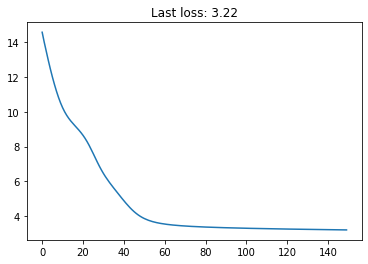

In [3]:
class Word2VecModel(Enum):
    SKIP_GRAM = 1
    CBOW = 2


class Word2Vec:
    
    def __init__(self, 
                 model=Word2VecModel.SKIP_GRAM,
                 learning_rate=1e-1,
                 window=3,
                 latent_space=5,
                 norm=True
    ):
        self.model = model
        self.window = window
        self.lr = learning_rate
        self.lt = latent_space
        self.norm = norm
       
    def tokenizer(self, corpus):
        phrases = corpus.strip().lower().split(".")
        return [words.strip().split() for words in phrases if len(words) > 0]

    def __generate_indexes(self, corpus):
        word_counts = defaultdict(int)
        for phrases in corpus:
            for word in phrases:
                word_counts[word] += 1
        v_count = len(word_counts.keys())

        words_list = list(word_counts.keys())
        word_index = dict((word, i) for i, word in enumerate(words_list))
        index_word = dict((i, word) for i, word in enumerate(words_list))
        return v_count, word_index, index_word
    
    def generate_embedding(self, corpus):
        self.v_count, self.word_index, self.index_word = self.__generate_indexes(corpus)

        keys = list(self.word_index.keys())
        oneHotEncoded = pd.get_dummies(keys)

        X, y = [], []
        for sentence in corpus:
            sent_len = len(sentence)
            for i, word in enumerate(sentence):
                w_target = oneHotEncoded[word].to_numpy()
                w_context = []
                for j in range(i-self.window, i+self.window+1):
                    if j!=i and j<=sent_len-1 and j>=0:
                        w_context += [oneHotEncoded[sentence[j]].to_numpy()]
                X += [w_target]
                y += [w_context]
        return np.asarray(X), y
    
    def __forward(self, bx):
        h = np.matmul(self.w1.T, bx) + self.b1
        u = np.matmul(self.w2.T, h) + self.b2
        return h, u, softmax(u, axis=0)
    
    def __backprop(self, dZ2, h, u, bx):
        dW2 = np.outer(h, dZ2)
        dB2 = np.sum(dZ2, axis=0)
        dZ1 = np.matmul(self.w2, dZ2)
        dW1 = np.outer(bx, dZ1)
        dB1 = np.sum(dZ1, axis=0)
        return dW1, dB1, dW2, dB2

    def __loss(self, u, bx, by):
        if self.model == Word2VecModel.SKIP_GRAM:
            k = [u[label == 1] if u[label == 1].size > 0 else 0 for label in by]
            return -np.sum(k) + len(by) * np.log(np.sum(np.exp(u)))
        elif self.model == Word2VecModel.CBOW:
            return -float(u[bx == 1]) + np.log(np.sum(np.exp(u)))
    
    def train(self, X, y, epochs=150, show_iter_err=50):
        size = X.shape[1]
        
        self.w1 = np.random.randn(size, self.lt) * np.sqrt(2 / (size + self.lt))
        self.w2 = np.random.randn(self.lt, size) * np.sqrt(2 / (self.lt + size))
        self.b1 = np.zeros((self.lt, ))
        self.b2 = np.zeros((size, ))
        
        _loss = []
        for epoch in range(epochs):
            loss = 0
            for bx, by in zip(X, y):
                # Forward
                if self.model == Word2VecModel.SKIP_GRAM:
                    x = np.copy(bx)
                elif self.model == Word2VecModel.CBOW:
                    x = np.mean(by, axis=0)
                h, u, yh = self.__forward(x)
                    
                # Backpropagation
                if self.model == Word2VecModel.SKIP_GRAM:
                    dZ2 = np.sum(yh - by, axis=0)
                elif self.model == Word2VecModel.CBOW:
                    dZ2 = yh - bx
                dW1, dB1, dW2, dB2 = self.__backprop(dZ2, h, u, x)
                
                # Update weights
                self.w1 -= self.lr * dW1
                self.b1 -= self.lr * dB1
                self.w2 -= self.lr * dW2
                self.b2 -= self.lr * dB2
                
                # Cost / Loss function
                loss += self.__loss(u, bx, by)
            _loss += [loss]
            if epoch % show_iter_err == 0 and epoch > 1:
                print(f"Epoch {epoch + 1}/{epochs} ====> Loss: {np.round(loss, 5)}")
        print(f"Epoch {epochs}/{epochs} ====> Loss: {np.round(loss, 5)}")
        
        if self.norm:
            self.wv = MinMaxScaler().fit_transform(self.w1)
        return _loss

    def find_similar(self, word, topn=10):
        word = self.word_index.get(word, None)
        if word is not None:
            c_wv = self.wv[word, :]
            sim = cosine_similarity(wv, [c_wv])
            words = list(zip(index_word.values(), sim.tolist()))
            words = sorted(words, key=lambda x: x[1], reverse=True)
            return words[:topn]
        return None
    
    def find_word(self, vector, topn=2):
        sim = euclidean_distances(self.wv, [vector], squared=True)
        return sorted(list(zip(self.index_word.values(), sim.tolist())), key=lambda x: x[1], reverse=False)[:topn]


w2v = Word2Vec(latent_space=2)
corpus = w2v.tokenizer(corpus)
X, y = w2v.generate_embedding(corpus)
loss = w2v.train(X, y)

plt.title(f"Last loss: {np.round(loss[-1], 2)}")
plt.plot(loss)
plt.show()

In [4]:
wv = w2v.wv
word_index = w2v.word_index
index_word = w2v.index_word
print(wv)

[[0.01133449 0.44907111]
 [0.50788999 1.        ]
 [0.56256227 0.007821  ]
 [1.         0.59063904]
 [0.         0.45269897]
 [0.5553712  0.        ]]


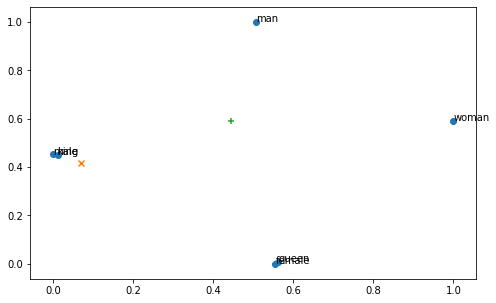

In [5]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1) #, projection='3d')
plt.scatter(wv[:, 0], wv[:, 1], marker='o', color='C0')
for i, txt in enumerate(w2v.word_index):
    plt.annotate(txt, (wv[i, 0], wv[i, 1]))

c_wv = wv[word_index["man"], :] + wv[word_index["queen"], :] - wv[word_index["woman"], :]
plt.scatter(c_wv[0], c_wv[1], marker='x', color='C1')
c_wv = wv[word_index["woman"], :] - wv[word_index["female"], :]
plt.scatter(c_wv[0], c_wv[1], marker='+', color='C2')
plt.show()

In [6]:
c_wv = wv[word_index["man"], :] + wv[word_index["queen"], :] - wv[word_index["woman"], :]
print(w2v.find_word(c_wv))

print()
c_wv = wv[word_index["woman"], :] - wv[word_index["female"], :]
print(w2v.find_word(c_wv))

print()
word = "king"
print(f"Closest words to: {word}")
print(w2v.find_similar(word, topn=2))

[('king', [0.004511828269042117]), ('male', [0.0062249787208106255])]

[('man', [0.17157837653292896]), ('king', [0.2077854383290919])]

Closest words to: king
[('king', [1.0]), ('male', [0.9996816268304719])]
